In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
#from ptitprince import RainCloud

from pandas_profiling import ProfileReport
%matplotlib inline
pd.set_option('display.max_rows', 50)

print(os.getcwd())

/content


In [4]:
from lightgbm import LGBMModel
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

In [5]:
INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Solafune/夜間光データから土地価格を予測/data/inputs/'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Solafune/夜間光データから土地価格を予測/data/outputs/'
NB_NAME = 'nb007'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train = pd.read_csv(os.path.join(INPUT_DIR, 'TrainDataSet.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'EvaluationData.csv'))
submission = pd.read_csv(os.path.join(INPUT_DIR, 'UploadFileTemplate.csv'))
target = train['AverageLandPrice']

# 前処理

In [6]:
# 面積を追加
def calc_area(input_df):
    output_df = input_df.copy()
    output_df['Area'] = input_df['SumLight'] / input_df['MeanLight']
    # 小数点以下でずれあるが、測定地域の面積は変わらないはずなので中央値に置き換え
    _mapping = output_df.groupby('PlaceID')['Area'].median()
    output_df['Area'] = output_df['PlaceID'].map(_mapping)
    # NaNがあるので0置き換え
    output_df['Area'] = output_df['Area'].fillna(0)
    return output_df

In [7]:
train = calc_area(train)
test = calc_area(test)

# 特徴量

In [8]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df) -> pd.DataFrame:
        raise NotImplementedError()

In [9]:
# count 63
class Count63Block(BaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame()
        output_df['PlaceID'] = input_df['PlaceID'].copy()

        _mapping = input_df[input_df['MeanLight'] == 63].groupby('PlaceID').size()
        output_df['count63'] = output_df['PlaceID'].map(_mapping).fillna(0)
        return output_df['count63']

In [10]:
# aggregationのagg_methodsで使用する関数群
# 分位点
def third_quartile(x):
    return x.quantile(0.75)
def first_quartile(x):
    return x.quantile(0.25)
def quartile_range(x):
    return x.quantile(0.75) - x.quantile(0.25)

def max_min(x):
    return x.max() - x.min()

In [11]:
# agg計算関数(xfeat.aggregation参照)
def aggregation(input_df, group_key, group_values, agg_methods):
    new_df = []
    print(f'{group_key}')
    for agg_method in agg_methods:
        for col in group_values:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            new_col = f"agg_{agg_method_name}_{col}_grpby_{group_key}"
            df_agg = (input_df[[col] + [group_key]].groupby(group_key)[[col]].agg(agg_method))
            df_agg.columns = [new_col]
            new_df.append(df_agg)
            
    _df = pd.concat(new_df, axis=1).reset_index()
    output_df = pd.merge(input_df[[group_key]], _df, on=group_key, how="left")
    return output_df.drop(group_key, axis=1)


# PlaceIDをキーにした集約特徴量
class AggPlaceIDBlock(BaseBlock):
    def __init__(self, group_values, agg_methods):
        self.group_values = group_values
        self.agg_methods = agg_methods

    def transform(self, input_df):
        output_df = aggregation(input_df,
                               'PlaceID',
                                group_values=self.group_values,
                                agg_methods=self.agg_methods)

        return output_df


# Year をキーにした集約特徴量
class AggYearBlock(BaseBlock):
    def __init__(self, group_values, agg_methods):
        self.group_values = group_values
        self.agg_methods = agg_methods

    def transform(self, input_df):
        output_df = aggregation(input_df,
                               'Year',
                                group_values=self.group_values,
                                agg_methods=self.agg_methods)
        return output_df

In [12]:
# diff計算関数
def diff_aggregation(input_df, group_key, group_values, num_diffs):
    dfs = []
    for nd in num_diffs:
        _df = input_df.groupby(group_key)[group_values].diff(nd)
        _df.columns = [f'diff={nd}_{col}_grpby_{group_key}' for col in group_values]
        dfs.append(_df)
    output_df = pd.concat(dfs, axis=1)
    return output_df


# PlaceID をキーにしたグループ内差分(マイナスからプラスまで差の取り方いっぱいあるな)
class LagPlaceIDBlock(BaseBlock):
    def __init__(self, group_key, group_values, num_diffs):
        self.group_key = group_key
        self.group_values = group_values
        self.num_diffs = num_diffs
    
    def transform(self, input_df):
        output_df = diff_aggregation(input_df,
                                     group_key=self.group_key,
                                     group_values=self.group_values,
                                     num_diffs=self.num_diffs)
        return output_df

In [13]:
# shift計算関数
def shift_aggregation(input_df, group_key, group_values, num_shifts):
    dfs = []
    for ns in num_shifts:
        _df = input_df.groupby(group_key)[group_values].shift(ns)
        _df.columns = [f'shift={ns}_{col}_grpby_{group_key}' for col in group_values]
        dfs.append(_df)
    output_df = pd.concat(dfs, axis=1)
    return output_df

# PlaceID をキーにしたグループ内シフト
# あまり意味ないかもしれない？
class ShiftPlaceIDBlock(BaseBlock):
    def __init__(self, group_key, group_values, num_shifts):
        self.group_key = group_key
        self.group_values = group_values
        self.num_shifts = num_shifts

    def transform(self, input_df):
        output_df = shift_aggregation(input_df,
                                      self.group_key,
                                      self.group_values,
                                      self.num_shifts)
        return output_df

In [14]:
# PCAを単体でするときのコンポーネント数
COMPONENT = 16

# 主性成分分析する
def make_vec_features(input_df, index, columns, values):
    all_pca_df = _all_df = pd.DataFrame()
    
    # valuesそれぞれでpivotしてpca
    for val in values:
        _df = pd.pivot_table(input_df, index=index, columns=columns, values=val).add_prefix(val + '=')
        _all_df = pd.concat([_all_df, _df], axis=1)
        sc_df = StandardScaler().fit_transform(_df.fillna(0))
        pca = PCA(n_components=COMPONENT, random_state=1993)
        pca_df = pd.DataFrame(pca.fit_transform(sc_df), index=_df.index).rename(columns=lambda x: f"PlaceID_{val}_PCA_{x:03}")
        all_pca_df = pd.concat([all_pca_df, pca_df], axis=1)
    # values全部でpca
    sc_all_df = StandardScaler().fit_transform(_all_df.fillna(0))
    pca = PCA(n_components=COMPONENT * (len(values)+1), random_state=1993)
    pca_df = pd.DataFrame(pca.fit_transform(sc_all_df), index=_all_df.index).rename(columns=lambda x:f"PlaceID_All_PCA_{x:03}")

    all_pca_df= pd.concat([all_pca_df, pca_df], axis=1)
    output_df = pd.merge(input_df[[index]], all_pca_df, left_on=index, right_index=True, how='left')
    return output_df.drop('PlaceID', axis=1)

# pivot tabel を用いた特徴量
class PlaceID2Vec(BaseBlock):
    def __init__(self, index, columns, values):
        self.index = index
        self.columns = columns
        self.values = values

    def transform(self, input_df):
        return make_vec_features(input_df, self.index, self.columns, self.values)

In [15]:
# PlaceIDをキーにしたグループ内相関係数
class PlaceIDcorr(BaseBlock):
    def __init__(self, group_key, group_values):
        self.group_key = group_key
        self.group_values = group_values

    def transform(self, input_df):
        dfs = []
        for gv in self.group_values:
            _df = input_df.groupby(self.group_key)[gv].corr().unstack().iloc[:, 1].rename(f"Corr={gv[0]}-{gv[1]}")
            dfs.append(pd.DataFrame(_df))
        dfs = pd.concat(dfs, axis=1)
        output_df = pd.merge(input_df[[self.group_key]], dfs, left_on=self.group_key, right_index=True, how='left').drop(self.group_key, axis=1)
        return output_df      

In [16]:
# 各特徴量同士の四則演算?


In [17]:
train

,PlaceID,Year,AverageLandPrice,MeanLight,SumLight,Area
0,1128,1993,740.909091,57.571430,403.0,7.0
1,1128,1994,739.390909,62.714287,439.0,7.0
2,1128,1995,739.390909,61.857143,433.0,7.0
3,1128,1996,739.390909,61.714287,432.0,7.0
4,1128,1997,739.390909,62.857143,440.0,7.0
...,...,...,...,...,...,...
21878,1141,2009,99.818182,10.978724,1032.0,89.0
21879,1141,2010,94.000000,16.734043,1573.0,89.0
21880,1141,2011,89.363636,12.595745,1184.0,89.0
21881,1141,2012,85.000000,13.775281,1226.0,89.0


In [18]:
# そのまま使う特徴量
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)

def origin_features(input_df):
    use_columns = [
        'Year',
        'MeanLight',
        'SumLight',
        'Area'
    ]
    return input_df[use_columns]

In [19]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None,format_str='{:.3f}[s]',prefix=None,suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time()-start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [20]:
from tqdm import tqdm

def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)

def to_feature(input_df, blocks, is_train=False):
    output_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    return output_df

In [21]:
agg_methods = ["min", "max", "median", "mean", "std", 'skew', max_min, third_quartile, first_quartile, quartile_range]

num_diffs = range(0, 22)
num_shifts = range(0, 22)
group_vlaues = [
    ["Year", "MeanLight"],
    ["Year", "SumLight"],
    ["Year", "Area"],
]         
#*[LagBlock(i,light_cols) for i in range(-lag,0)],

process_blocks = [
    WrapperBlock(origin_features),
    Count63Block(),
    AggPlaceIDBlock(["MeanLight", "SumLight", "Area"], agg_methods),
    AggYearBlock(["MeanLight", "SumLight", "Area"], agg_methods),
    LagPlaceIDBlock('PlaceID', ["MeanLight", "SumLight"], num_diffs),
    ShiftPlaceIDBlock('PlaceID', ["MeanLight", "SumLight"], num_shifts),
    PlaceID2Vec("PlaceID", "Year", ["Area", "MeanLight", "SumLight"]),
    PlaceIDcorr("PlaceID", group_vlaues),
]

train_feat_df = to_feature(train, process_blocks, is_train=True)
test_feat_df = to_feature(test, process_blocks, is_train=False)

  0%|          | 0/8 [00:00<?, ?it/s]

create<__main__.WrapperBlock object at 0x7f482bcb4210> 0.008[s]
create<__main__.Count63Block object at 0x7f482bcb4550> 0.006[s]
PlaceID


 38%|███▊      | 3/8 [00:08<00:13,  2.74s/it]

create<__main__.AggPlaceIDBlock object at 0x7f482bcb4810> 8.199[s]
Year


 50%|█████     | 4/8 [00:08<00:08,  2.01s/it]

create<__main__.AggYearBlock object at 0x7f482bcb4410> 0.298[s]


 62%|██████▎   | 5/8 [00:14<00:09,  3.28s/it]

create<__main__.LagPlaceIDBlock object at 0x7f482bcb4090> 6.230[s]
create<__main__.ShiftPlaceIDBlock object at 0x7f482bcb4050> 0.073[s]


 88%|████████▊ | 7/8 [00:15<00:02,  2.36s/it]

create<__main__.PlaceID2Vec object at 0x7f482bcb4110> 0.261[s]


  0%|          | 0/8 [00:00<?, ?it/s]

create<__main__.PlaceIDcorr object at 0x7f4832906e90> 1.322[s]
create<__main__.WrapperBlock object at 0x7f482bcb4210> 0.001[s]
create<__main__.Count63Block object at 0x7f482bcb4550> 0.004[s]
PlaceID


 38%|███▊      | 3/8 [00:05<00:08,  1.67s/it]

create<__main__.AggPlaceIDBlock object at 0x7f482bcb4810> 5.001[s]
Year


 50%|█████     | 4/8 [00:05<00:05,  1.26s/it]

create<__main__.AggYearBlock object at 0x7f482bcb4410> 0.303[s]


 88%|████████▊ | 7/8 [00:09<00:01,  1.41s/it]

create<__main__.LagPlaceIDBlock object at 0x7f482bcb4090> 3.646[s]
create<__main__.ShiftPlaceIDBlock object at 0x7f482bcb4050> 0.064[s]
create<__main__.PlaceID2Vec object at 0x7f482bcb4110> 0.099[s]


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]

create<__main__.PlaceIDcorr object at 0x7f4832906e90> 0.803[s]


In [22]:
train_feat_df.filter(like='diff')

,diff=0_MeanLight_grpby_PlaceID,diff=0_SumLight_grpby_PlaceID,diff=1_MeanLight_grpby_PlaceID,diff=1_SumLight_grpby_PlaceID,diff=2_MeanLight_grpby_PlaceID,diff=2_SumLight_grpby_PlaceID,diff=3_MeanLight_grpby_PlaceID,diff=3_SumLight_grpby_PlaceID,diff=4_MeanLight_grpby_PlaceID,diff=4_SumLight_grpby_PlaceID,diff=5_MeanLight_grpby_PlaceID,diff=5_SumLight_grpby_PlaceID,diff=6_MeanLight_grpby_PlaceID,diff=6_SumLight_grpby_PlaceID,diff=7_MeanLight_grpby_PlaceID,diff=7_SumLight_grpby_PlaceID,diff=8_MeanLight_grpby_PlaceID,diff=8_SumLight_grpby_PlaceID,diff=9_MeanLight_grpby_PlaceID,diff=9_SumLight_grpby_PlaceID,diff=10_MeanLight_grpby_PlaceID,diff=10_SumLight_grpby_PlaceID,diff=11_MeanLight_grpby_PlaceID,diff=11_SumLight_grpby_PlaceID,diff=12_MeanLight_grpby_PlaceID,diff=12_SumLight_grpby_PlaceID,diff=13_MeanLight_grpby_PlaceID,diff=13_SumLight_grpby_PlaceID,diff=14_MeanLight_grpby_PlaceID,diff=14_SumLight_grpby_PlaceID,diff=15_MeanLight_grpby_PlaceID,diff=15_SumLight_grpby_PlaceID,diff=16_MeanLight_grpby_PlaceID,diff=16_SumLight_grpby_PlaceID,diff=17_MeanLight_grpby_PlaceID,diff=17_SumLight_grpby_PlaceID,diff=18_MeanLight_grpby_PlaceID,diff=18_SumLight_grpby_PlaceID,diff=19_MeanLight_grpby_PlaceID,diff=19_SumLight_grpby_PlaceID,diff=20_MeanLight_grpby_PlaceID,diff=20_SumLight_grpby_PlaceID,diff=21_MeanLight_grpby_PlaceID,diff=21_SumLight_grpby_PlaceID
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,5.142857,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,-0.857144,-6.0,4.285713,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,-0.142856,-1.0,-1.000000,-7.0,4.142857,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.142856,8.0,1.000000,7.0,0.142856,1.0,5.285713,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,0.0,0.0,-0.661726,-4.0,-1.167344,-49.0,0.776476,124.0,1.158499,158.0,-0.639253,-2.0,1.945016,228.0,-1.189815,-51.0,-1.021276,-36.0,-2.369590,-156.0,-0.414534,18.0,-0.234759,34.0,0.158499,69.0,-1.920152,-116.0,-1.897681,-114.0,-2.538130,-171.0,2.012432,234.0,0.416926,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21879,0.0,0.0,5.755319,541.0,5.093593,537.0,4.587975,492.0,6.531795,665.0,6.913818,699.0,5.116066,539.0,7.700335,769.0,4.565504,490.0,4.734043,505.0,3.385729,385.0,5.340785,559.0,5.520560,575.0,5.913818,610.0,3.835167,425.0,3.857638,427.0,3.217189,370.0,7.767751,775.0,6.172245,633.0,NaN,NaN,NaN,NaN,NaN,NaN
21880,0.0,0.0,-4.138298,-389.0,1.617021,152.0,0.955295,148.0,0.449677,103.0,2.393497,276.0,2.775520,310.0,0.977768,150.0,3.562037,380.0,0.427206,101.0,0.595745,116.0,-0.752569,-4.0,1.202487,170.0,1.382262,186.0,1.775520,221.0,-0.303131,36.0,-0.280660,38.0,-0.921109,-19.0,3.629453,386.0,2.033947,244.0,NaN,NaN,NaN,NaN
21881,0.0,0.0,1.179536,42.0,-2.958762,-347.0,2.796557,194.0,2.134831,190.0,1.629213,145.0,3.573033,318.0,3.955056,352.0,2.157304,192.0,4.741573,422.0,1.606742,143.0,1.775281,158.0,0.426967,38.0,2.382023,212.0,2.561798,228.0,2.955056,263.0,0.876405,78.0,0.898876,80.0,0.258427,23.0,4.808989,428.0,3.213483,286.0,NaN,NaN


In [23]:
train_feat_df.shape

(21883, 268)

In [24]:
# GroupKFold
from sklearn.model_selection import GroupKFold
fold = GroupKFold(n_splits=5)
cv = list(fold.split(train,target,train['PlaceID']))

In [25]:
# RMSLE → RMSE
y = np.log1p(target)

# Model

In [26]:
!pip install catboost

     |████████████████████████████████| 67.3MB 43kB/s 


In [27]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoost
from catboost import Pool
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

In [28]:
from abc import abstractmethod
class Base_Model(object):
    @abstractmethod
    def fit(self, x_train, y_train, x_valid, y_valid):
        raise NotImplementedError

    @abstractmethod
    def predict(self, model, features):
        raise NotImplementedError

    def cv(self, y_train, train_features, test_features, fold_ids):
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))

        for i_fold, (trn_idx, val_idx) in enumerate(fold_ids):
            x_trn = train_features.iloc[trn_idx]
            y_trn = y_train[trn_idx]
            x_val = train_features.iloc[val_idx]
            y_val = y_train[val_idx]

            with timer(prefix=f'fit fold={i_fold}'):
                model = self.fit(x_trn, y_trn, x_val, y_val)

            oof_preds[val_idx] = self.predict(model, x_val)
            oof_score = np.sqrt(mean_squared_error(y_val, oof_preds[val_idx]))
            print('fold{}:RMSLE{}'.format(i_fold, oof_score))
            test_preds += self.predict(model, test_features) / len(fold_ids)

        oof_score = np.sqrt(mean_squared_error(y_train, oof_preds))
        print(f'oof score: {oof_score}')

        evals_results = {"evals_result": {
            "oof_score": oof_score,
            "n_data": len(train_features),
            "n_features": len(train_features.columns),
        }}

        return oof_preds, test_preds, evals_results

In [29]:
cat_col = []
class Lgbm(Base_Model):
    def __init__(self, model_params):
        self.model_params = model_params
        self.models = []
        self.feature_cols = None

    def fit(self, x_train, y_train, x_valid, y_valid):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_valid = lgb.Dataset(x_valid, y_valid)

        model = lgb.train(self.model_params,
            train_set=lgb_train,
            valid_sets=[lgb_valid],
            valid_names=['valid'],
            categorical_feature=cat_col,
            early_stopping_rounds=20,
            num_boost_round=10000,
            verbose_eval=False)
        self.models.append(model)
        return model

    def predict(self, model, features):
        self.feature_cols = features.columns
        return model.predict(features)

    def visualize_importance(self):
        feature_importance_df = pd.DataFrame()

        for i,model in enumerate(self.models):
            _df = pd.DataFrame()
            _df['feature_importance'] = model.feature_importance(importance_type='gain')
            _df['column'] = self.feature_cols
            _df['fold'] = i+1
            feature_importance_df = pd.concat([feature_importance_df, _df],axis=0, ignore_index=True)

        order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False).index[:50]

        fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
        sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
        ax.tick_params(axis='x', rotation=90)
        ax.grid()
        fig.tight_layout()
        return fig,ax

class Cat(Base_Model):
    def __init__(self, model_params):
        self.model_params = model_params
        
    def fit(self, x_train, y_train, x_valid, y_valid):
        train_pool = Pool(x_train,
                          label=y_train,
                          cat_features=cat_col)
        valid_pool = Pool(x_valid,
                          label=y_valid,
                          cat_features=cat_col)

        model = CatBoost(self.model_params)
        model.fit(train_pool,
                  early_stopping_rounds=30,
                 plot=False,
                 use_best_model=True,
                 eval_set=[valid_pool],
                  verbose=False)

        return model

    def predict(self, model, features):
      pred = model.predict(features)
      return pred

class Xgb(Base_Model):
    def __init__(self,model_params):
        self.model_params = model_params

    def fit(self, x_train, y_train, x_valid, y_valid):
        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)

        evals = [(xgb_train, 'train'),(xgb_valid, 'eval')]

        model = xgb.train(self.model_params,
                         xgb_train,
                         num_boost_round=2000,
                         early_stopping_rounds=20,
                         evals=evals,
                         verbose_eval=False)

        return model

    def predict(self, model, features):
        return model.predict(xgb.DMatrix(features))

class Rid(Base_Model):
    def __init__(self):
      self.model = None
    def fit(self, x_train, y_train, x_valid, y_valid):
        model =Ridge(
            alpha=1, #L2係数
            max_iter=1000,
            random_state=10,
                              )
        model.fit(x_train, y_train)
        return model

    def predict(self,model, features):
      return model.predict(features)

# Learning

In [30]:
cat_col =[]
cat_params = {
    'loss_function': 'RMSE',
    'num_boost_round': 10000,
    'depth':7
}

cat_model = Cat(cat_params)
oof_preds_cat, test_preds_cat, evals_results_cat = cat_model.cv(
    y, train_feat_df, test_feat_df, cv
)

fit fold=040.602[s]
fold0:RMSLE0.5454712653526694
fit fold=157.945[s]
fold1:RMSLE0.5235929980899053
fit fold=2137.070[s]
fold2:RMSLE0.589766785639812
fit fold=390.554[s]
fold3:RMSLE0.5073273913103951
fit fold=491.323[s]
fold4:RMSLE0.5724879893860164
oof score: 0.5485684937821393


In [31]:
lgbm_params = {
    "boosting_type": "gbdt",
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves':20,
    'learning_rate':0.01,
    "verbose":-1
}

lgbm_model = Lgbm(lgbm_params)
oof_preds_lgb, test_preds_lgb, evals_results_lgb = lgbm_model.cv(
    y, train_feat_df, test_feat_df, cv
)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=021.700[s]
fold0:RMSLE0.5561546906061172


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=139.643[s]
fold1:RMSLE0.5241599062198454


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=248.819[s]
fold2:RMSLE0.5866203052701143


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=347.043[s]
fold3:RMSLE0.5140347964959983


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=434.345[s]
fold4:RMSLE0.5749777608121298
oof score: 0.5519070771431291


In [32]:
xgb_params = {
    'max_depth': 6,
    'lambda':10, 
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    'tree_method':'gpu_hist',
    'learning_rate':0.01
}

xgb_model = Xgb(xgb_params)
oof_preds_xgb, test_preds_xgb, evals_results_xgb = xgb_model.cv(
    y, train_feat_df, test_feat_df, cv
)

fit fold=08.240[s]
fold0:RMSLE0.5650683143320937
fit fold=18.254[s]
fold1:RMSLE0.5298459653827817
fit fold=28.934[s]
fold2:RMSLE0.5922960347514146
fit fold=37.892[s]
fold3:RMSLE0.5070774900662198
fit fold=49.255[s]
fold4:RMSLE0.5686436034470347
oof score: 0.5534145999753824


# Stacking

In [33]:
stack_train_df = pd.DataFrame([oof_preds_cat, oof_preds_lgb, oof_preds_xgb]).T
stack_test_df = pd.DataFrame([test_preds_cat, test_preds_lgb, test_preds_lgb]).T

In [34]:
stack_model = Rid()
oof_preds_stack, test_preds_stack, evals_results_stack = stack_model.cv(
    y, stack_train_df, stack_test_df, cv
)

fit fold=00.010[s]
fold0:RMSLE0.5506954177603239
fit fold=10.002[s]
fold1:RMSLE0.5154533399882958
fit fold=20.002[s]
fold2:RMSLE0.5820033828154129
fit fold=30.002[s]
fold3:RMSLE0.5027974005191143
fit fold=40.002[s]
fold4:RMSLE0.5661060051161239
oof score: 0.5442367467042996


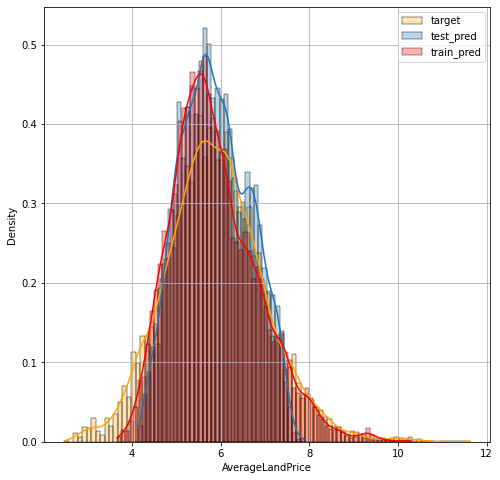

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(y, label='target', kde=True, stat='density', common_norm=False, alpha=0.3, color='orange')
sns.histplot(test_preds_stack, label='test_pred', kde=True, stat='density', common_norm=False, alpha=0.3)
sns.histplot(oof_preds_stack, label='train_pred', kde=True, stat='density', common_norm=False, alpha=0.3, color='red')
ax.legend()
ax.grid()

(<Figure size 1440x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f480014b410>)

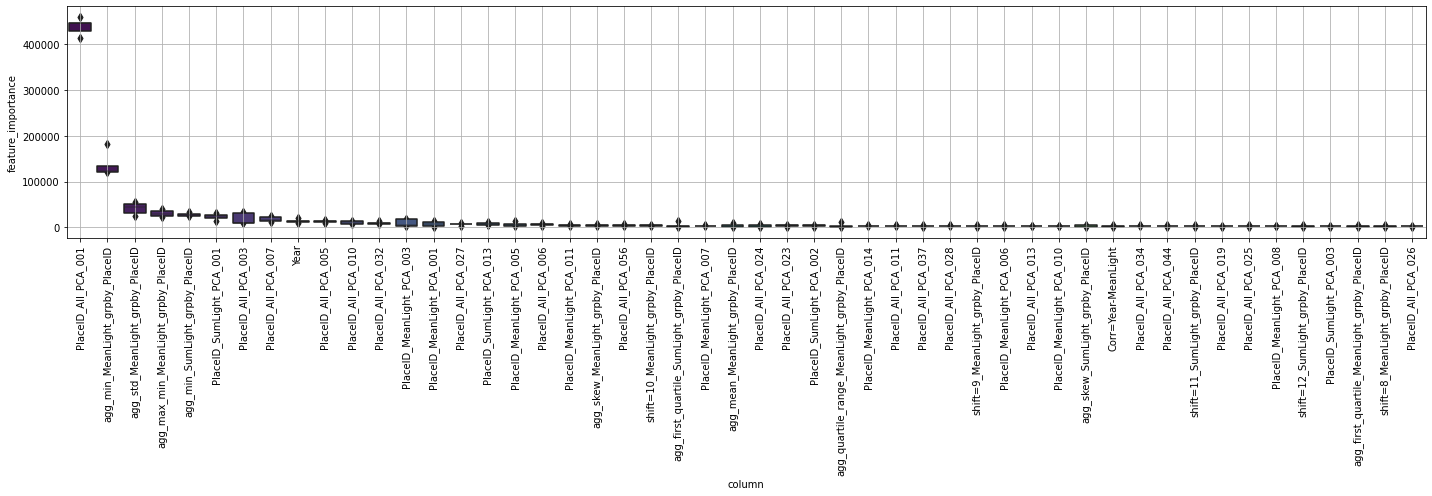

In [36]:
lgbm_model.visualize_importance()

In [37]:
y_sub = np.expm1(test_preds_stack)
submission['LandPrice'] = y_sub

submission.to_csv(os.path.join(OUTPUT_DIR, 'sub_' + NB_NAME + '.csv'), index=False)